In [ ]:
import tensorflow as tf
import os

import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras import layers
from keras import optimizers
from tensorflow.keras.optimizers import SGD
from keras import backend as K

import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, GammaRegressor, PoissonRegressor, TweedieRegressor
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from sklearn import tree

import pydotplus
import six
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/final_data.csv')
#df['Time'] = pd.DatetimeIndex(df['DateTime']).time
df.set_index('date',inplace=True)
df = df.drop("Weather",1) # due to amount of missing data
df = df.drop("Station Name",1) # location is not important and it's all in toronto

for i in df.columns[df.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    df[i].fillna(df[i].mean(),inplace=True) # fill in missing data with average of column
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


,Weekday,Month,Hour,Day,DateTime,HvacMode,Schedule,T_ctrl,T_stp_cool,T_stp_heat,...,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill
date,,,,,,,,,,,,,,,,,,,,,
1/1/2019,1,1,0,1,1/1/2019 0:00,heat,Sleep,70,71,63,...,0:00,4.5,3.7,94.0,18.0,14.0,6.4,97.29,0,0
1/1/2019,1,1,1,1,1/1/2019 1:00,heat,Sleep,71,71,63,...,1:00,4.4,3.6,94.0,27.0,7.0,9.7,97.32,0,0
1/1/2019,1,1,2,1,1/1/2019 2:00,heat,Sleep,69,71,63,...,2:00,2.4,1.5,94.0,33.0,35.0,9.7,97.54,0,0
1/1/2019,1,1,3,1,1/1/2019 3:00,heat,Sleep,69,71,63,...,3:00,2.2,1.2,93.0,31.0,29.0,19.3,97.89,0,0
1/1/2019,1,1,4,1,1/1/2019 4:00,heat,Sleep,69,71,63,...,4:00,1.9,0.8,92.0,31.0,30.0,24.1,98.16,0,0


create new variable "in-Out" which is differnce between indoor and outdoor temperature 

In [ ]:
df['In-Out'] = df['Thermostat_Temperature'] - df['Temp (°C)']
df.head()
# saving file
#df.to_csv("final_data", sep='\t')

,Weekday,Month,Hour,Day,DateTime,HvacMode,Schedule,T_ctrl,T_stp_cool,T_stp_heat,...,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,In-Out
date,,,,,,,,,,,,,,,,,,,,,
1/1/2019,1,1,0,1,1/1/2019 0:00,heat,Sleep,70,71,63,...,4.5,3.7,94.0,18.0,14.0,6.4,97.29,0,0,66.5
1/1/2019,1,1,1,1,1/1/2019 1:00,heat,Sleep,71,71,63,...,4.4,3.6,94.0,27.0,7.0,9.7,97.32,0,0,66.6
1/1/2019,1,1,2,1,1/1/2019 2:00,heat,Sleep,69,71,63,...,2.4,1.5,94.0,33.0,35.0,9.7,97.54,0,0,67.6
1/1/2019,1,1,3,1,1/1/2019 3:00,heat,Sleep,69,71,63,...,2.2,1.2,93.0,31.0,29.0,19.3,97.89,0,0,66.8
1/1/2019,1,1,4,1,1/1/2019 4:00,heat,Sleep,69,71,63,...,1.9,0.8,92.0,31.0,30.0,24.1,98.16,0,0,66.1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5498 entries, 1/1/2019 to 12/31/2019
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Weekday                      5498 non-null   int64  
 1   Month                        5498 non-null   int64  
 2   Hour                         5498 non-null   int64  
 3   Day                          5498 non-null   int64  
 4   DateTime                     5498 non-null   object 
 5   HvacMode                     5498 non-null   object 
 6   Schedule                     5498 non-null   object 
 7   T_ctrl                       5498 non-null   int64  
 8   T_stp_cool                   5498 non-null   int64  
 9   T_stp_heat                   5498 non-null   int64  
 10  delta                        5498 non-null   int64  
 11  Humidity                     5498 non-null   int64  
 12  HumidityExpectedLow          5498 non-null   int64  
 13  HumidityEx

In [ ]:
# encode catogrical varibales like HvacMode and Schedule and make sure time variables are not of type objec
ohe = OneHotEncoder()
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['HvacMode'] = df['HvacMode'].astype(str)
df['Schedule'] = df['Schedule'].astype(str)
ohe=OneHotEncoder(sparse=False)
df['HvacMode'] = ohe.fit_transform(df[['HvacMode']])
print(ohe.categories_)
df['Schedule'] = ohe.fit_transform(df[['Schedule']])
print(ohe.categories_)
df.head()

[array(['auto', 'cool', 'heat', 'off'], dtype=object)]
[array(['Away', 'Home', 'Sleep'], dtype=object)]


,Weekday,Month,Hour,Day,DateTime,HvacMode,Schedule,T_ctrl,T_stp_cool,T_stp_heat,...,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,In-Out
date,,,,,,,,,,,,,,,,,,,,,
1/1/2019,1,1,0,1,2019-01-01 00:00:00,0.0,0.0,70,71,63,...,4.5,3.7,94.0,18.0,14.0,6.4,97.29,0,0,66.5
1/1/2019,1,1,1,1,2019-01-01 01:00:00,0.0,0.0,71,71,63,...,4.4,3.6,94.0,27.0,7.0,9.7,97.32,0,0,66.6
1/1/2019,1,1,2,1,2019-01-01 02:00:00,0.0,0.0,69,71,63,...,2.4,1.5,94.0,33.0,35.0,9.7,97.54,0,0,67.6
1/1/2019,1,1,3,1,2019-01-01 03:00:00,0.0,0.0,69,71,63,...,2.2,1.2,93.0,31.0,29.0,19.3,97.89,0,0,66.8
1/1/2019,1,1,4,1,2019-01-01 04:00:00,0.0,0.0,69,71,63,...,1.9,0.8,92.0,31.0,30.0,24.1,98.16,0,0,66.1


In [ ]:
# check HvacMode and Schedule values
print(df['HvacMode'].unique())
print(df['Schedule'].unique())

[0. 1.]
[0. 1.]


In [ ]:
tmp = df.copy() # this si to drop time and date variable to use in random forest
tmp = tmp.drop("Time",1)
#tmp = tmp.drop("date",1)
tmp = tmp.drop("DateTime",1)
y = tmp['auxHeat1'].values
x = tmp.drop("auxHeat1",1).values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


Start with using a random forest to get feature importance

In [ ]:
# define the model
model = RandomForestRegressor(n_estimators=100)
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -23.551 (2.001)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


<BarContainer object of 40 artists>

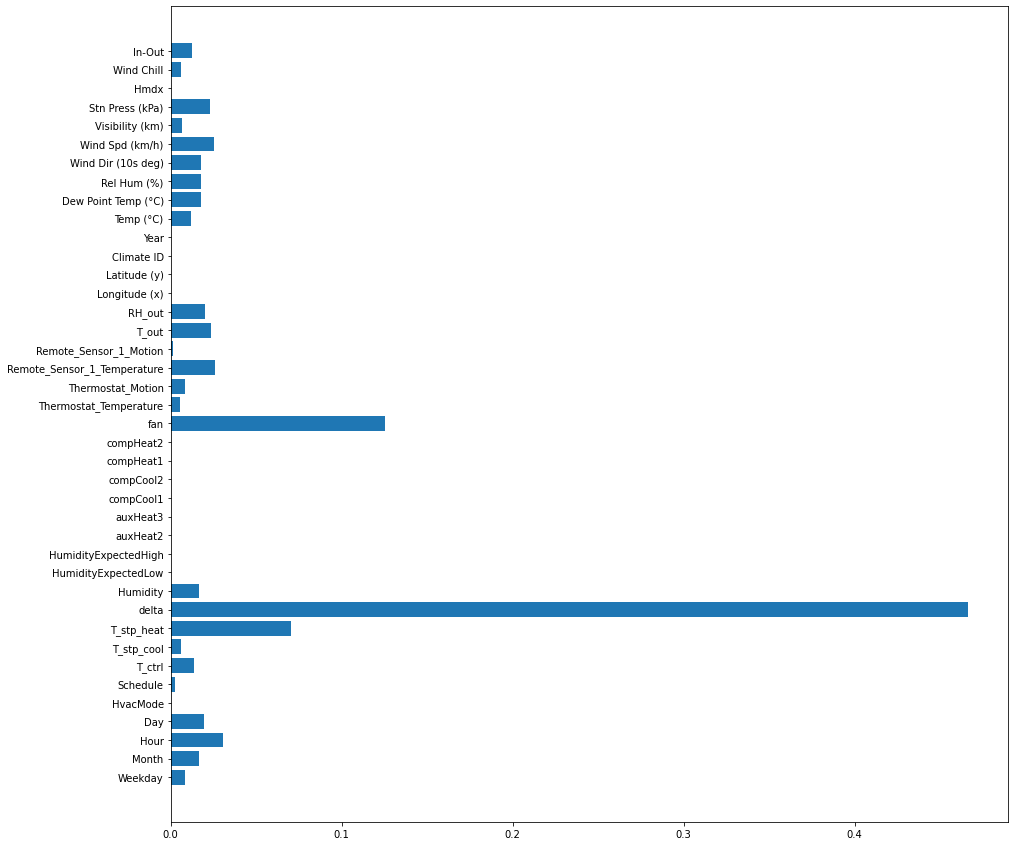

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=12)
model.fit(X_train, y_train)
tmp = tmp.drop("auxHeat1",1) # to fix error plotting
plt.figure(figsize = (15, 15))
plt.barh(tmp.columns, model.feature_importances_)

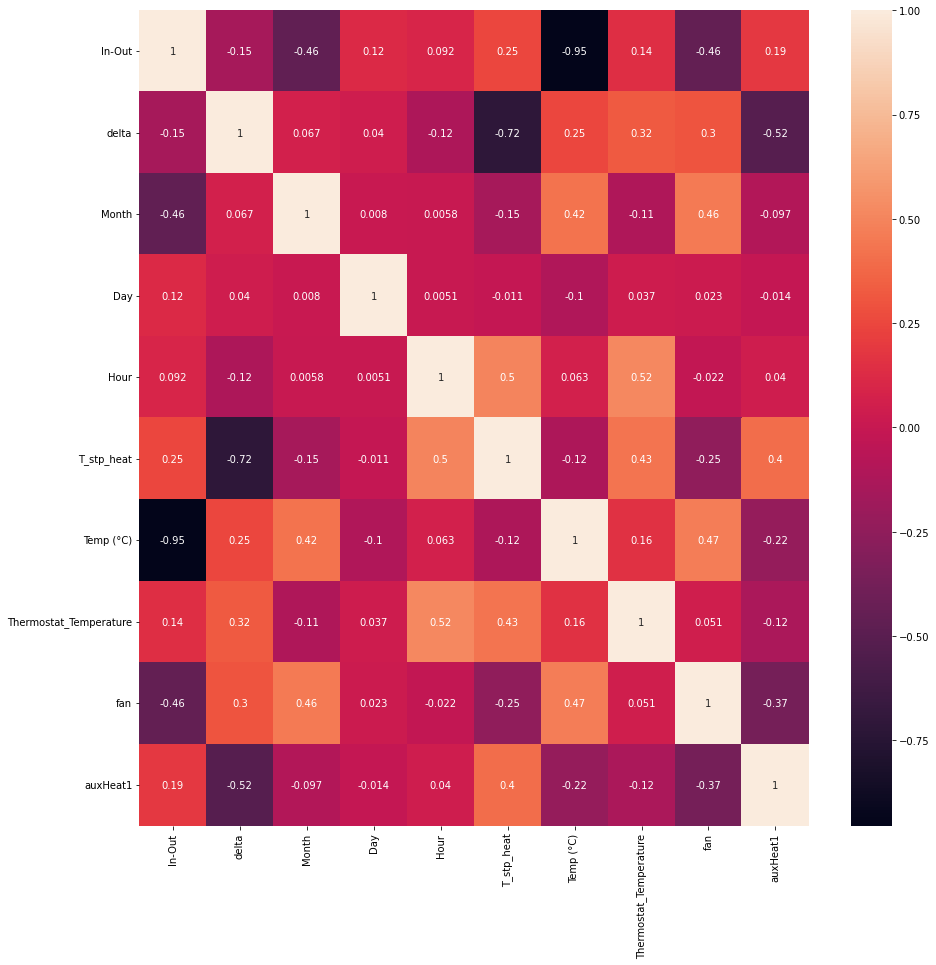

In [ ]:
# correlations wiht only variable of interest as requested by Supervisor
tmp_df1 = df[['In-Out','delta','Month','Day','Hour','T_stp_heat','Temp (°C)','Thermostat_Temperature','fan','auxHeat1']] # with time series
tmp_df2 = df[['In-Out','delta','T_stp_heat','Temp (°C)','Thermostat_Temperature','fan','auxHeat1']] # without time series
plt.figure(figsize = (15, 15))
sns.heatmap(tmp_df1.corr(), annot=True)

Based on the graph above the most important variable is delta which is the difference between the thermostat temperature and the fan. Note that the time series element namely the date and time variables had to be removed to use random forest. So take these feature importances with a grain of salt

Lets's start with the ANN used in the Paper: "Predicting indoor temperature from smart thermostat and weather forecast data" which had 8 inputs and 1 hidden layer with 4 nuerons.
The variable going to be used are based on previous papers and from the code above and EDA. To keep things consistent 8 varible will be used here as well. these variables are:


1.   delta
2.   Month
3.   Day
3.   Hour
3.   T_ctrl
4.   Fan
5.   T_stp_Heat
6.   Temp (°C) (outdoor temperature)
8.   In-Out



Will have 5 folds loss will be MSE, reporting on MSE, RMSE, MAE, R2

In [ ]:
# function for R2 since keras does not natively have this
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def r2(y_true, y_pred):
    """
    R^2 (coefficient of determination) regression score function.
    Best possible score is 1.0, lower values are worse.
    Args:
        y_true ([np.array]): test samples
        y_pred ([np.array]): predicted samples
    Returns:
        [float]: R2    
    """
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

In [ ]:
# function for RMSE since keras does not natively have this
def RMSE(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
# normalize data
tmp_df1 = (tmp_df1-tmp_df1.mean())/tmp_df1.std()
tmp_df2 = (tmp_df2-tmp_df2.mean())/tmp_df2.std()

In [ ]:
y = tmp_df1['auxHeat1'].values
x = tmp_df1.drop("auxHeat1",1).values
#x = np.asarray(x).astype(np.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
b = tmp_df2['auxHeat1'].values
a = tmp_df2.drop("auxHeat1",1).values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
tmp_df1.head()

,In-Out,delta,Month,Day,Hour,T_stp_heat,Temp (°C),Thermostat_Temperature,fan,auxHeat1
date,,,,,,,,,,
1/1/2019,-0.015105,1.744044,-1.291141,-1.680271,-1.643302,-1.10539,0.243244,0.758287,-0.681644,-0.430698
1/1/2019,-0.002989,1.744044,-1.291141,-1.680271,-1.499565,-1.10539,0.231163,0.758287,-0.681644,-0.430698
1/1/2019,0.118174,1.433386,-1.291141,-1.680271,-1.355828,-1.10539,-0.010468,0.356798,-0.681644,-0.430698
1/1/2019,0.021244,1.122729,-1.291141,-1.680271,-1.212091,-1.10539,-0.034631,-0.044691,-0.681644,-0.430698
1/1/2019,-0.063570,0.812071,-1.291141,-1.680271,-1.068354,-1.10539,-0.070876,-0.446180,-0.681644,-0.430698


In [ ]:
tmp_df2.head()

,In-Out,delta,T_stp_heat,Temp (°C),Thermostat_Temperature,fan,auxHeat1
date,,,,,,,
1/1/2019,-0.015105,1.744044,-1.10539,0.243244,0.758287,-0.681644,-0.430698
1/1/2019,-0.002989,1.744044,-1.10539,0.231163,0.758287,-0.681644,-0.430698
1/1/2019,0.118174,1.433386,-1.10539,-0.010468,0.356798,-0.681644,-0.430698
1/1/2019,0.021244,1.122729,-1.10539,-0.034631,-0.044691,-0.681644,-0.430698
1/1/2019,-0.063570,0.812071,-1.10539,-0.070876,-0.446180,-0.681644,-0.430698


In [ ]:
folds = KFold(n_splits=5, random_state=1, shuffle=True) # code taken from DS 8013 A2

cols = ["Fold","Set","Loss (MSE)","RMSE","MAE","R2"]
output = pd.DataFrame(columns = cols)
fold = 0

for train, test in folds.split(x, y):

    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(4, use_bias = True, input_dim=(x_train.shape[1]), activation='relu'))
    model.add(Dense(1, use_bias =True, activation='linear'))
    model.compile(loss='mse', optimizer='sgd',  metrics=[RMSE,'mae',r2])

    hist = model.fit(x_train, y_train, epochs=100, batch_size=10, verbose=0, validation_split = 0.2)
    train_mse = model.evaluate(x_train, y_train)
    
    vals = [fold+1,"Train",train_mse[0],train_mse[1],train_mse[2],train_mse[3]]
    tmp = {}
    for i in range(len(cols)):
      tmp[cols[i]] = vals[i]  
    output = output.append(tmp, ignore_index=True)
    
    test_mse = model.evaluate(x_test, y_test)

    vals = [fold+1,"Test",test_mse[0],test_mse[1],train_mse[2],train_mse[3]]
    tmp = {}
    for i in range(len(cols)):
      tmp[cols[i]] = vals[i]  
    output = output.append(tmp, ignore_index=True)

    fold += 1

35/35 [==============================] - 0s 2ms/step - loss: 0.4201 - RMSE: 0.5918 - mae: 0.3606 - r2: -65239.8398


In [ ]:
print(output)

  Fold    Set  Loss (MSE)      RMSE       MAE             R2
0    1  Train    0.382140  0.547894  0.328968  -81124.375000
1    1   Test    0.419265  0.585010  0.328968  -81124.375000
2    2  Train    0.395939  0.558972  0.313407  -98553.937500
3    2   Test    0.405177  0.587825  0.313407  -98553.937500
4    3  Train    0.546601  0.695208  0.507896 -250257.062500
5    3   Test    0.523962  0.682153  0.507896 -250257.062500
6    4  Train    0.414173  0.578690  0.357435  -61333.675781
7    4   Test    0.397662  0.549655  0.357435  -61333.675781
8    5  Train    0.402954  0.565198  0.349102  -97780.406250
9    5   Test    0.420105  0.591761  0.349102  -97780.406250


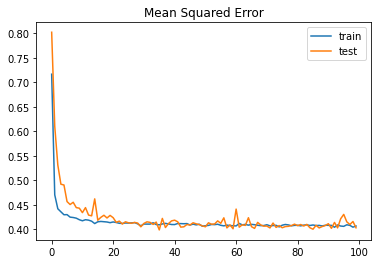

In [ ]:
# plot loss during training
plt.title('Mean Squared Error')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

The model perfromed horribly across all used metrics. This is possible due to the simplicty of the model. NExt we shall add an extra layer and more neurons

In [ ]:
folds = KFold(n_splits=5, random_state=1, shuffle=True) # code taken from DS 8013 A2

cols = ["Fold","Set","Loss (MSE)","RMSE","MAE","R2"]
output2 = pd.DataFrame(columns = cols)
fold = 0

for train, test in folds.split(x, y):

    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(16, use_bias = True, input_dim=(x_train.shape[1]), activation='relu'))
    model.add(Dense(8))
    model.add(Dense(4))
    model.add(Dense(1, activation='linear', use_bias =True))
    opt = SGD(lr=0.0001, momentum=0.9, clipvalue=0.5)
    model.compile(loss='mse', optimizer=opt,  metrics=[RMSE,'mae',r2])

    hist = model.fit(x_train, y_train, epochs=100, batch_size=30, verbose=0, validation_split = 0.2)
    train_mse = model.evaluate(x_train, y_train)
    
    vals = [fold+1,"Train",train_mse[0],train_mse[1],train_mse[2],train_mse[3]]
    tmp = {}
    for i in range(len(cols)):
      tmp[cols[i]] = vals[i]  
    output2 = output.append(tmp, ignore_index=True)
    
    test_mse = model.evaluate(x_test, y_test)

    vals = [fold+1,"Test",test_mse[0],test_mse[1],train_mse[2],train_mse[3]]
    tmp = {}
    for i in range(len(cols)):
      tmp[cols[i]] = vals[i]  
    output2 = output.append(tmp, ignore_index=True)

    fold += 1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


35/35 [==============================] - 0s 2ms/step - loss: 0.4349 - RMSE: 0.6184 - mae: 0.4343 - r2: -104999.7578


In [ ]:
print(output2)

   Fold    Set  Loss (MSE)      RMSE       MAE             R2
0     1  Train    0.382140  0.547894  0.328968  -81124.375000
1     1   Test    0.419265  0.585010  0.328968  -81124.375000
2     2  Train    0.395939  0.558972  0.313407  -98553.937500
3     2   Test    0.405177  0.587825  0.313407  -98553.937500
4     3  Train    0.546601  0.695208  0.507896 -250257.062500
5     3   Test    0.523962  0.682153  0.507896 -250257.062500
6     4  Train    0.414173  0.578690  0.357435  -61333.675781
7     4   Test    0.397662  0.549655  0.357435  -61333.675781
8     5  Train    0.402954  0.565198  0.349102  -97780.406250
9     5   Test    0.420105  0.591761  0.349102  -97780.406250
10    5   Test    0.434904  0.618413  0.424419 -182697.953125


In [ ]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 16)                160       
                                                                 
 dense_27 (Dense)            (None, 8)                 136       
                                                                 
 dense_28 (Dense)            (None, 4)                 36        
                                                                 
 dense_29 (Dense)            (None, 1)                 5         
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________
None


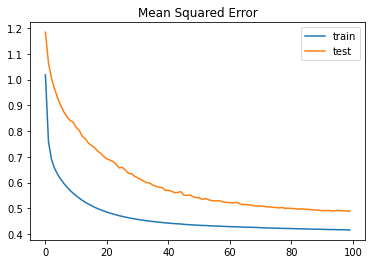

In [ ]:
# plot loss during training
plt.title('Mean Squared Error')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

Now lets use the non timer series data

In [ ]:
folds = KFold(n_splits=5, random_state=1, shuffle=True) # code taken from DS 8013 A2

cols = ["Fold","Set","Loss (MSE)","RMSE","MAE","R2"]
output = pd.DataFrame(columns = cols)
fold = 0

for train, test in folds.split(a, b):

    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(4, use_bias = True, input_dim=(x_train.shape[1]), activation='relu'))
    model.add(Dense(1, use_bias =True, activation='linear'))
    model.compile(loss='mse', optimizer='sgd',  metrics=[RMSE,'mae',R2])

    hist = model.fit(x_train, y_train, epochs=100, batch_size=10, verbose=0, validation_split = 0.2)
    train_mse = model.evaluate(x_train, y_train)
    
    vals = [fold+1,"Train",train_mse[0],train_mse[1],train_mse[2],train_mse[3]]
    tmp = {}
    for i in range(len(cols)):
      tmp[cols[i]] = vals[i]  
    output = output.append(tmp, ignore_index=True)
    
    test_mse = model.evaluate(x_test, y_test)

    vals = [fold+1,"Test",test_mse[0],test_mse[1],train_mse[2],train_mse[3]]
    tmp = {}
    for i in range(len(cols)):
      tmp[cols[i]] = vals[i]  
    output = output.append(tmp, ignore_index=True)

    fold += 1

35/35 [==============================] - 0s 2ms/step - loss: 0.3828 - RMSE: 0.5677 - mae: 0.3034 - R2: -1865679.0000


In [ ]:
print(output)

  Fold    Set  Loss (MSE)      RMSE       MAE           R2
0    1  Train    0.379746  0.536693  0.311486 -1794113.500
1    1   Test    0.402349  0.561437  0.311486 -1794113.500
2    2  Train    0.507889  0.608817  0.393087 -1933545.000
3    2   Test    0.522554  0.651749  0.393087 -1933545.000
4    3  Train    0.403056  0.562285  0.333117 -2305638.750
5    3   Test    0.377656  0.551240  0.333117 -2305638.750
6    4  Train    0.398724  0.578041  0.371471 -2752000.750
7    4   Test    0.393551  0.559604  0.371471 -2752000.750
8    5  Train    0.361821  0.535863  0.290493 -2068916.625
9    5   Test    0.382788  0.567720  0.290493 -2068916.625


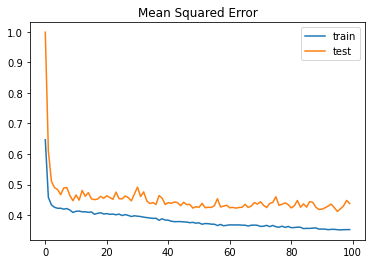

In [ ]:
# plot loss during training
plt.title('Mean Squared Error')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
folds = KFold(n_splits=5, random_state=1, shuffle=True) # code taken from DS 8013 A2

cols = ["Fold","Set","Loss (MSE)","RMSE","MAE","R2"]
output2 = pd.DataFrame(columns = cols)
fold = 0

for train, test in folds.split(a, b):

    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(16, use_bias = True, input_dim=(x_train.shape[1]), activation='relu'))
    model.add(Dense(8))
    model.add(Dense(4))
    model.add(Dense(1, activation='linear', use_bias =True))
    opt = SGD(lr=0.0001, momentum=0.9, clipvalue=0.5)
    model.compile(loss='mse', optimizer=opt,  metrics=[RMSE,'mae',r2])

    hist = model.fit(x_train, y_train, epochs=100, batch_size=30, verbose=0, validation_split = 0.2)
    train_mse = model.evaluate(x_train, y_train)
    
    vals = [fold+1,"Train",train_mse[0],train_mse[1],train_mse[2],train_mse[3]]
    tmp = {}
    for i in range(len(cols)):
      tmp[cols[i]] = vals[i]  
    output2 = output.append(tmp, ignore_index=True)
    
    test_mse = model.evaluate(x_test, y_test)

    vals = [fold+1,"Test",test_mse[0],test_mse[1],train_mse[2],train_mse[3]]
    tmp = {}
    for i in range(len(cols)):
      tmp[cols[i]] = vals[i]  
    output2 = output.append(tmp, ignore_index=True)

    fold += 1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


35/35 [==============================] - 0s 2ms/step - loss: 0.4295 - RMSE: 0.6123 - mae: 0.4099 - R2: -2802748.0000


In [ ]:
print(output2)

   Fold    Set  Loss (MSE)      RMSE       MAE           R2
0     1  Train    0.379746  0.536693  0.311486 -1794113.500
1     1   Test    0.402349  0.561437  0.311486 -1794113.500
2     2  Train    0.507889  0.608817  0.393087 -1933545.000
3     2   Test    0.522554  0.651749  0.393087 -1933545.000
4     3  Train    0.403056  0.562285  0.333117 -2305638.750
5     3   Test    0.377656  0.551240  0.333117 -2305638.750
6     4  Train    0.398724  0.578041  0.371471 -2752000.750
7     4   Test    0.393551  0.559604  0.371471 -2752000.750
8     5  Train    0.361821  0.535863  0.290493 -2068916.625
9     5   Test    0.382788  0.567720  0.290493 -2068916.625
10    5   Test    0.429452  0.612290  0.404885 -5213215.000


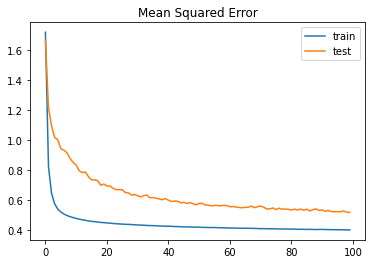

In [ ]:
# plot loss during training
plt.title('Mean Squared Error')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

Now let's use the LSTM 

In [ ]:
folds = KFold(n_splits=5, random_state=1, shuffle=True) # code taken from DS 8013 A2

cols = ["Fold","Set","Loss (MSE)","RMSE","MAE","R2"]
output = pd.DataFrame(columns = cols)
fold = 0

for train, test in folds.split(a, b):

    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(4, use_bias = True, input_dim=(x_train.shape[1]), activation='relu'))
    model.add(Dense(1, use_bias =True, activation='linear'))
    model.compile(loss='mse', optimizer='sgd',  metrics=[RMSE,'mae',r2])

    hist = model.fit(x_train, y_train, epochs=100, batch_size=10, verbose=0, validation_split = 0.2)
    train_mse = model.evaluate(x_train, y_train)
    
    vals = [fold+1,"Train",train_mse[0],train_mse[1],train_mse[2],train_mse[3]]
    tmp = {}
    for i in range(len(cols)):
      tmp[cols[i]] = vals[i]  
    output = output.append(tmp, ignore_index=True)
    
    test_mse = model.evaluate(x_test, y_test)

    vals = [fold+1,"Test",test_mse[0],test_mse[1],train_mse[2],train_mse[3]]
    tmp = {}
    for i in range(len(cols)):
      tmp[cols[i]] = vals[i]  
    output = output.append(tmp, ignore_index=True)

    fold += 1

35/35 [==============================] - 0s 2ms/step - loss: 0.4089 - RMSE: 0.5855 - mae: 0.3237 - R2: -1746196.7500


In [ ]:
print(output)

  Fold    Set  Loss (MSE)      RMSE       MAE           R2
0    1  Train    0.403914  0.556530  0.325173 -1881541.375
1    1   Test    0.438916  0.594767  0.325173 -1881541.375
2    2  Train    0.424579  0.564662  0.319251 -2313189.250
3    2   Test    0.428730  0.601572  0.319251 -2313189.250
4    3  Train    0.396858  0.558804  0.324929 -2049230.375
5    3   Test    0.353054  0.527287  0.324929 -2049230.375
6    4  Train    0.431899  0.592652  0.400044 -2410571.500
7    4   Test    0.425347  0.581436  0.400044 -2410571.500
8    5  Train    0.373425  0.544173  0.302795 -2894449.000
9    5   Test    0.408946  0.585470  0.302795 -2894449.000


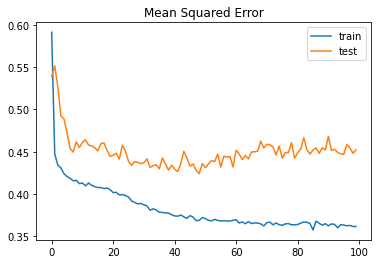

In [ ]:
# plot loss during training
plt.title('Mean Squared Error')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

Now we will use Linear Refression to see if an less complex model performs well on the dataset since so fa only neureal networks hae been used.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
LR = LinearRegression()
LR.fit(x_train,y_train)

LinearRegression()

In [ ]:
y_pred = LR.predict(x_test)
y_pred

array([ 0.19896118,  0.23350662, -0.17643934, ..., -0.15505076,
        0.49522537,  0.07486156])

In [ ]:
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_abosulte_error is ',mean_absolute_error(y_test,y_pred))
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.34023625751524633
mean_abosulte_error is  0.6678194408811435
mean_sqrd_error is  0.7439666623474971
root_mean_squared error of is  0.862535020939728


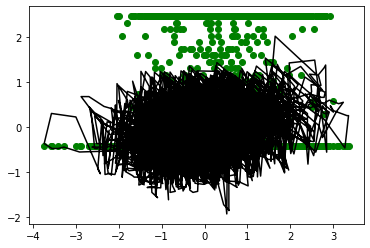

In [ ]:
plt.scatter(x[:,0], y, color='g') # printing regression plot of fitted model
plt.plot(x[:,0], LR.predict(x), color='k')
plt.show()

The regression model also perfoms horribly across all metrics. The model does not map the relationship between variables at all as can be seen in the graph above and further down below.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(a, b, test_size = 0.2, random_state = 42)
LR.fit(x_train,y_train)

LinearRegression()

In [ ]:
y_pred = LR.predict(x_test)
y_pred

array([ 0.15565857,  0.27156433, -0.29484192, ..., -0.17783753,
        0.57844909,  0.06599792])

In [ ]:
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_abosulte_error is ',mean_absolute_error(y_test,y_pred))
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.3293671027907896
mean_abosulte_error is  0.6741045681446806
mean_sqrd_error is  0.7562230023707283
root_mean_squared error of is  0.8696108338623251


Here the results are slighty worse without including the time series variables in the model

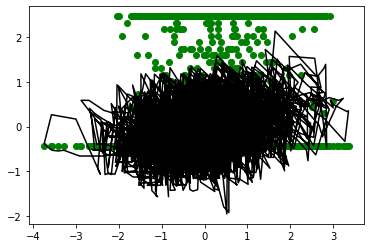

In [ ]:
plt.scatter(a[:,0], b, color='g') # printing regression plot of fitted model
plt.plot(a[:,0], LR.predict(a), color='k')
plt.show()

it wsa to be expected that a simple linear regression model would not perform well for such a task. Which is why A Generalized Linear Model (GLM) will be used next.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
pr = TweedieRegressor(alpha=0, fit_intercept=False)
y_pred = pr.fit(x_train, y_train).predict(x_test)

In [ ]:
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_abosulte_error is ',mean_absolute_error(y_test,y_pred))
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.3426409457721574
mean_abosulte_error is  0.6715726206535804
mean_sqrd_error is  0.741255073666157
root_mean_squared error of is  0.8609617144020731


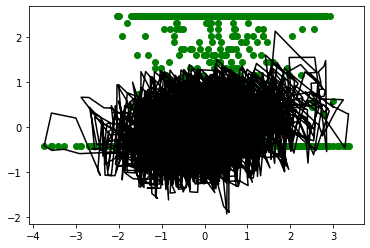

In [ ]:
plt.scatter(x[:,0], b, color='g') # printing regression plot of fitted model
plt.plot(x[:,0], pr.predict(x), color='k')
plt.show()

In [ ]:
# without timeseries element
x_train, x_test, y_train, y_test = train_test_split(a, b, test_size = 0.2, random_state = 42)

In [ ]:
pr = TweedieRegressor(alpha=0, max_iter=3000)
y_pred = pr.fit(x_train, y_train).predict(x_test)

In [ ]:
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_abosulte_error is ',mean_absolute_error(y_test,y_pred))
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.3309680026659293
mean_abosulte_error is  0.6743517220216809
mean_sqrd_error is  0.7544177862605269
root_mean_squared error of is  0.8685722688760716


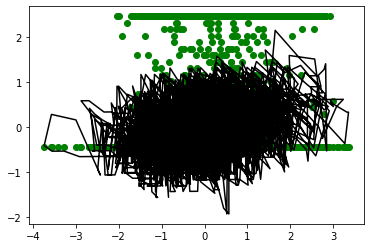

In [ ]:
plt.scatter(a[:,0], b, color='g') # printing regression plot of fitted model
plt.plot(a[:,0], pr.predict(a), color='k')
plt.show()

Random Forest was used to determine important features. However let's see how it actually performs on both versions of the data.

In [ ]:
# define the model
model = RandomForestRegressor(n_estimators=100)
# evaluate the model
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=12)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# report performance
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_abosulte_error is ',mean_absolute_error(y_test,y_pred))
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.6165455552181726
mean_abosulte_error is  0.2501891828590345
mean_sqrd_error is  0.3768564993991073
root_mean_squared error of is  0.6138863896512997


In [ ]:
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in model.estimators_:
  if (i_tree < 1):        
    export_graphviz(tree_in_forest,
                feature_names=tmp_df1.drop("auxHeat1",1).columns,
                filled=True,
                rounded=True)
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree = i_tree + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


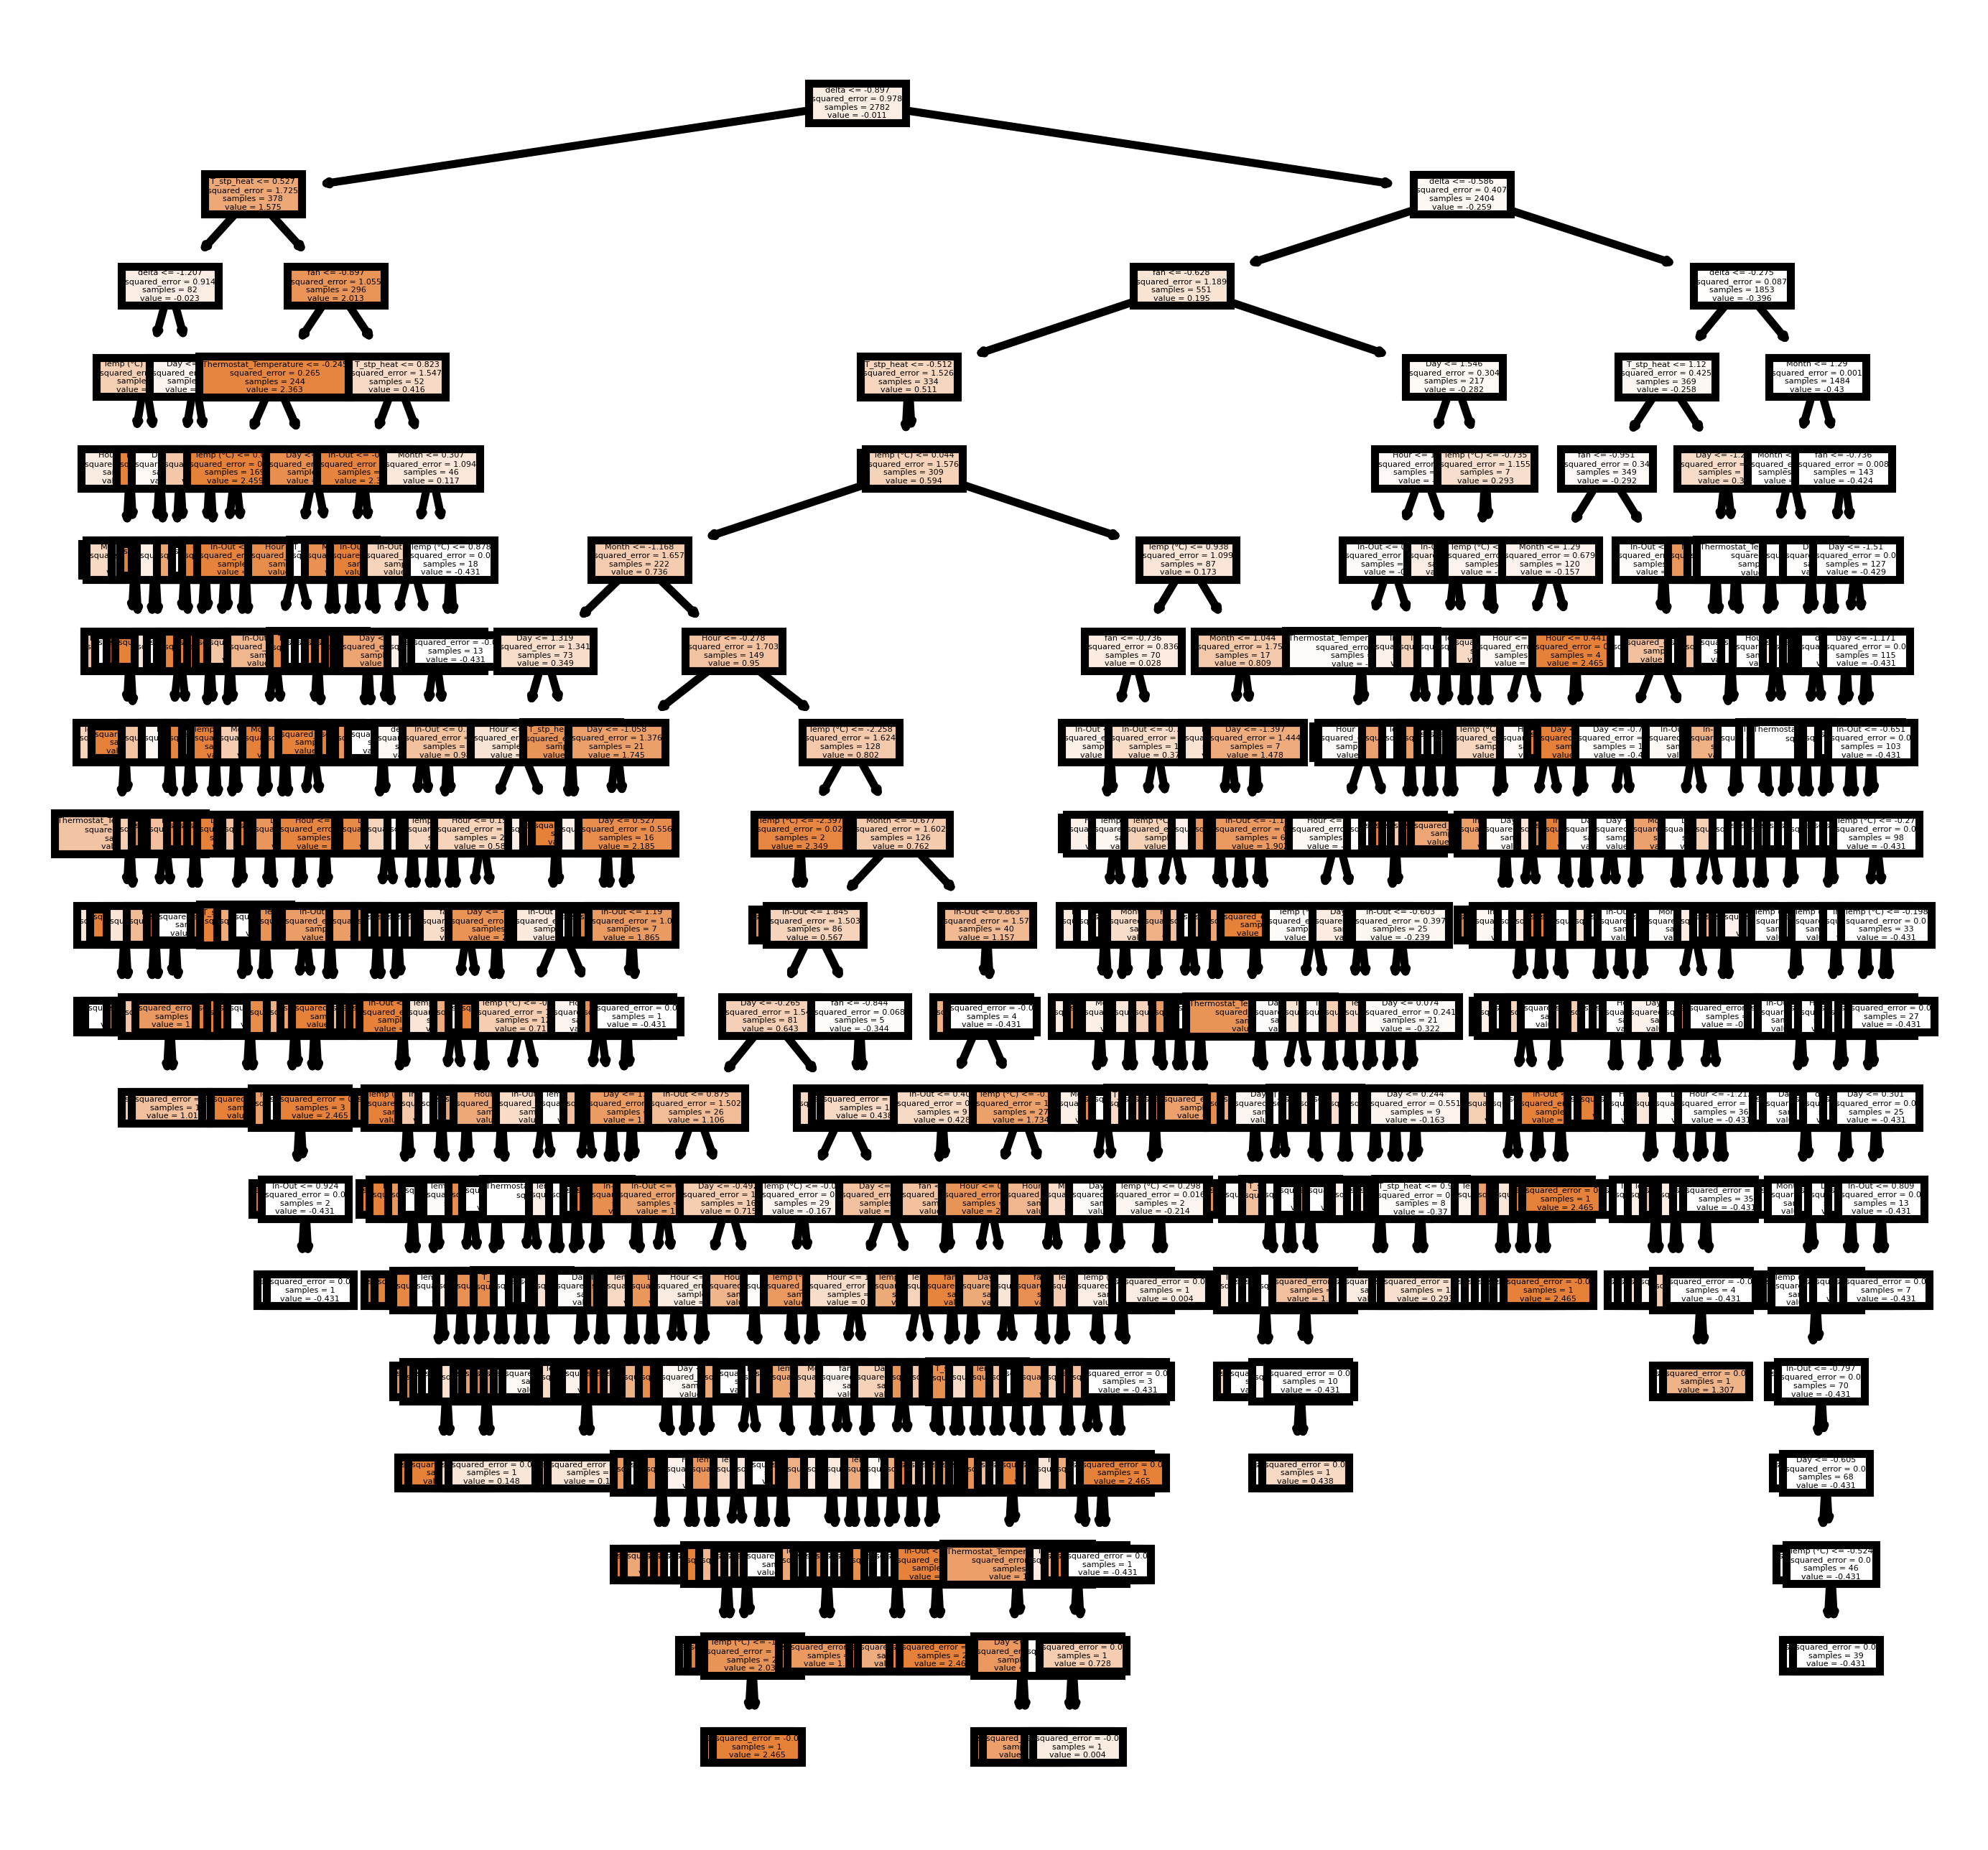

In [ ]:
fn=['In-Out','delta','Month','Day','Hour','T_stp_heat','Temp (°C)','Thermostat_Temperature','fan']
cn=['auxHeat1']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800) # one decision tree from random forest
tree.plot_tree(model.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

In [ ]:
# define the model
model = RandomForestRegressor(n_estimators=100)
# evaluate the model
X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.20, random_state=12)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# report performance
score=r2_score(y_test,y_pred)
print('r2 score is ',score)
print('mean_abosulte_error is ',mean_absolute_error(y_test,y_pred))
print('mean_sqrd_error is ',mean_squared_error(y_test,y_pred))
print('root_mean_squared error of is ',np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score is  0.5431955333508134
mean_abosulte_error is  0.2645661209448103
mean_sqrd_error is  0.4489444171373111
root_mean_squared error of is  0.6700331462974881


In [ ]:
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in model.estimators_:
  if (i_tree < 1):        
    export_graphviz(tree_in_forest,
                feature_names=tmp_df2.drop("auxHeat1",1).columns,
                filled=True,
                rounded=True)
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree = i_tree + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


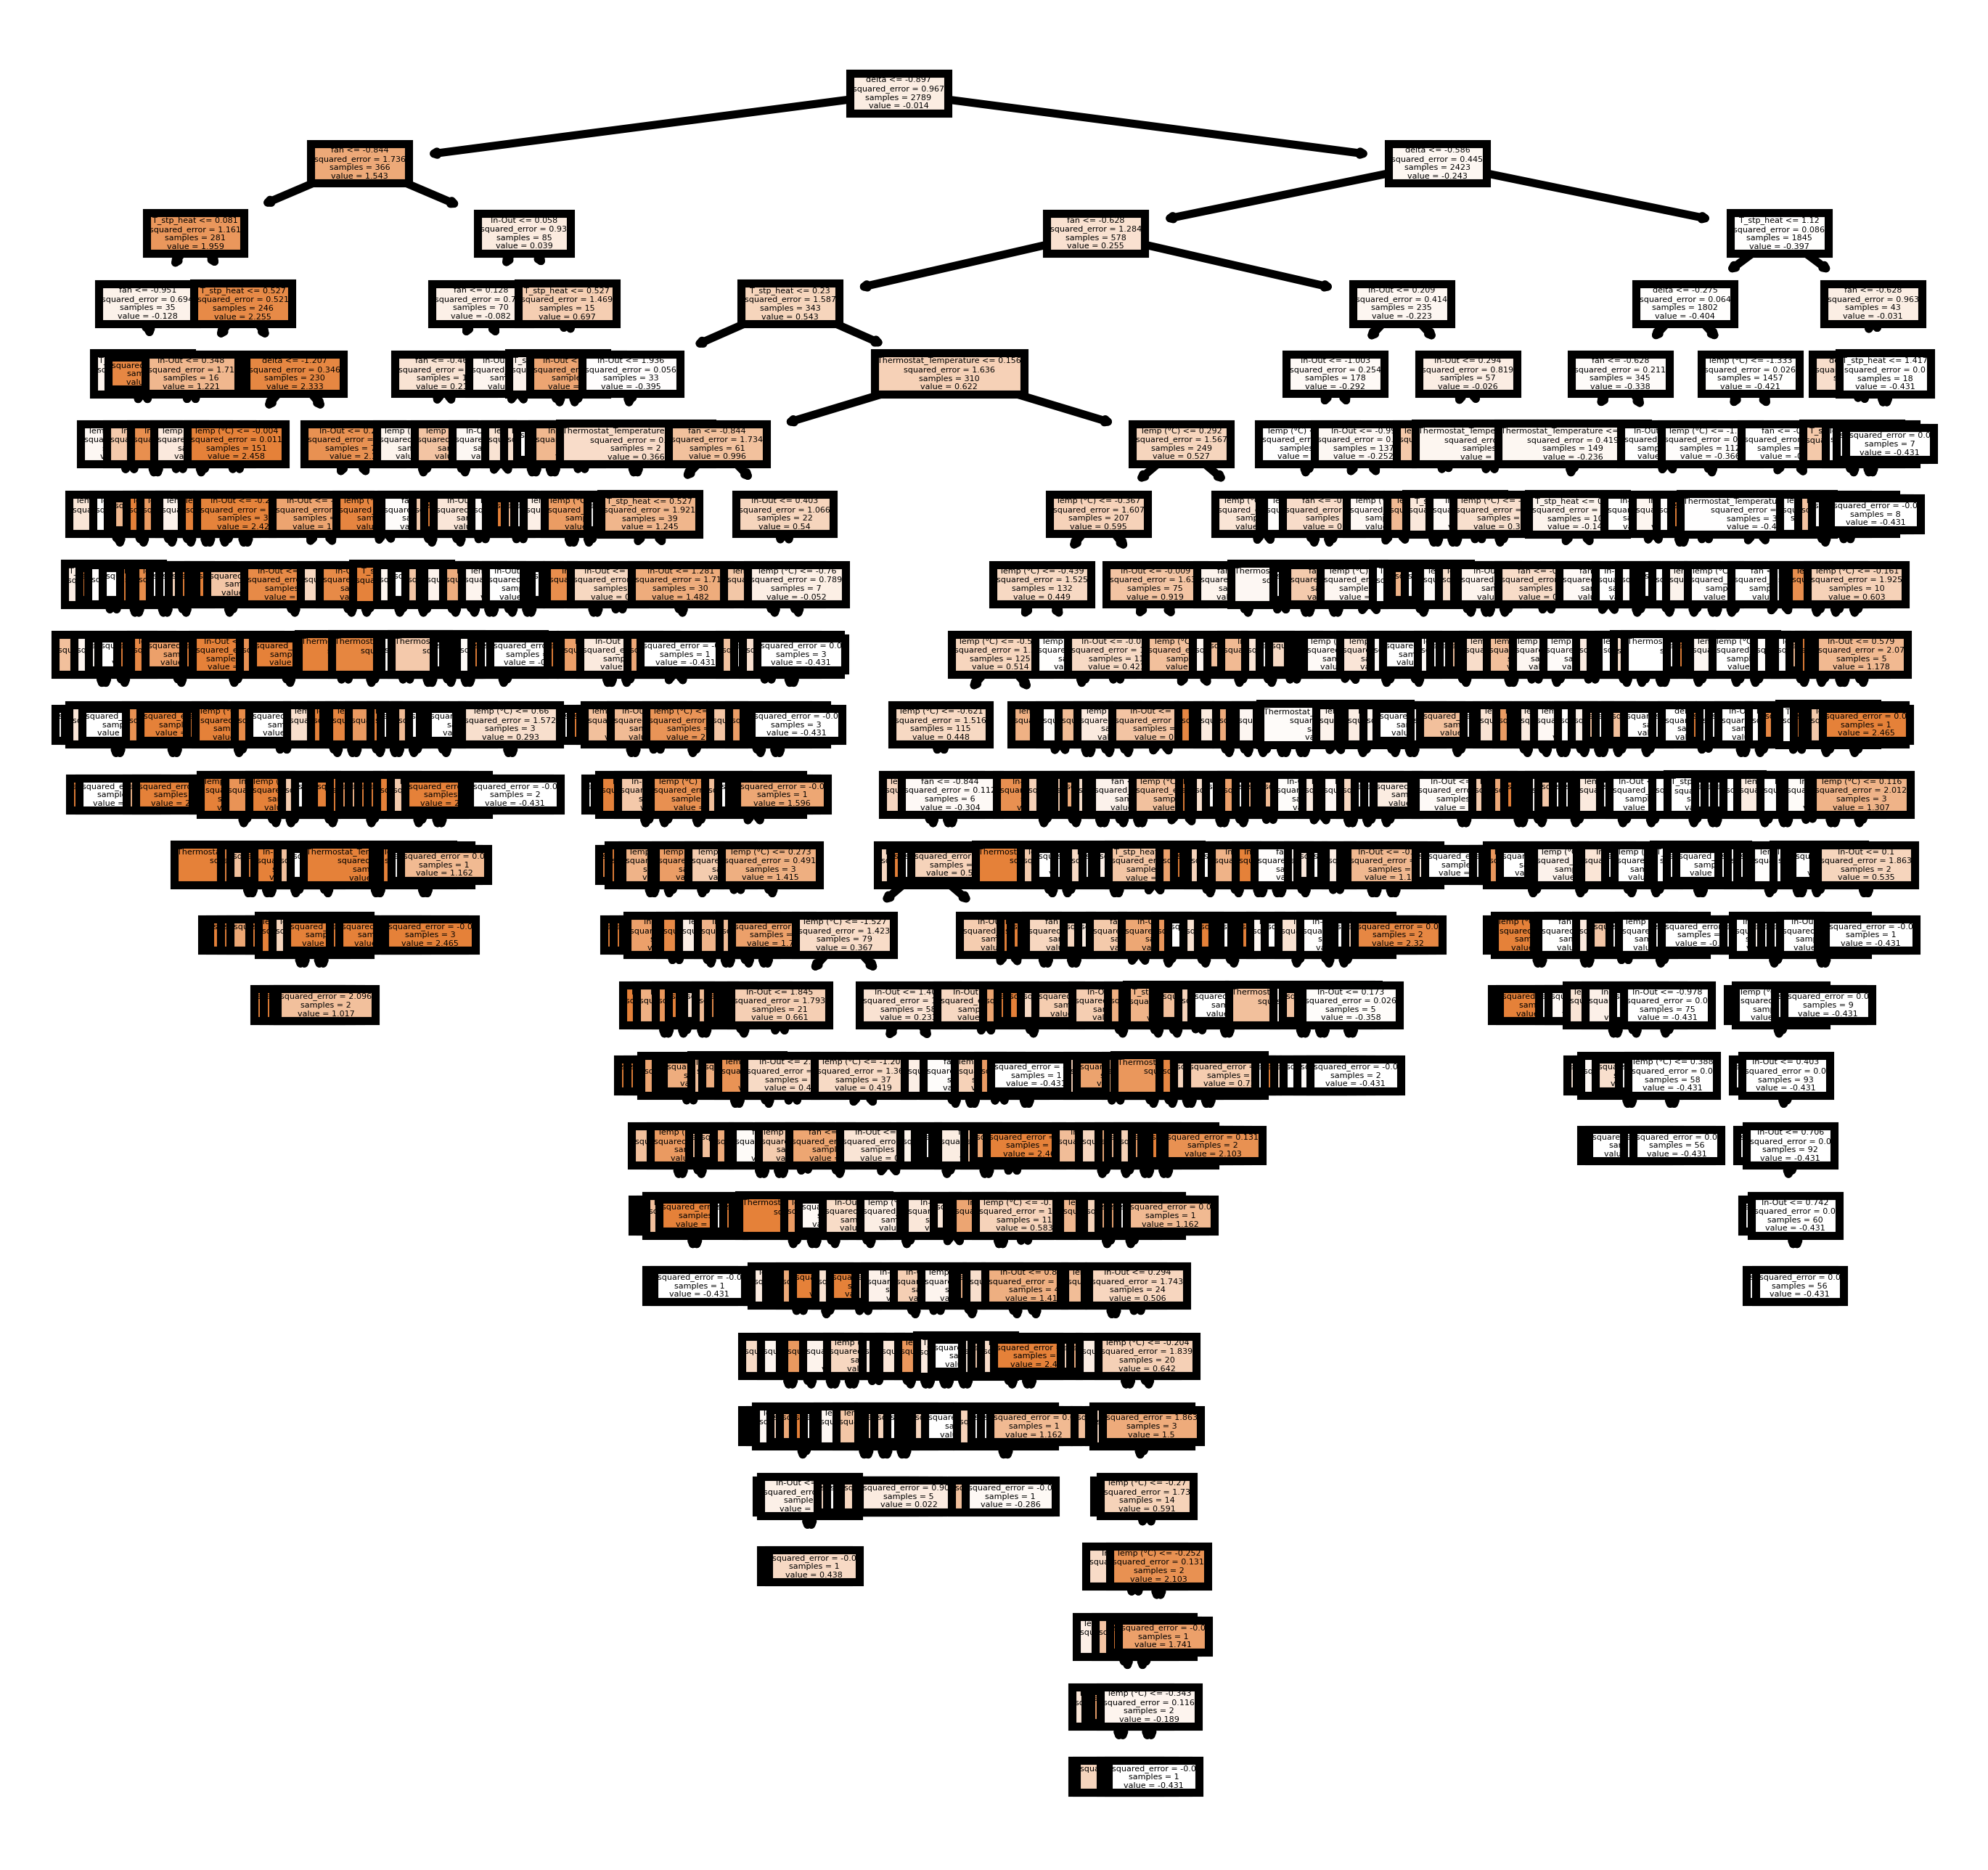

In [ ]:
fn=['In-Out','delta','T_stp_heat','Temp (°C)','Thermostat_Temperature','fan']
cn=['auxHeat1']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800) # one decision tree from random forest
tree.plot_tree(model.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

Random Forest perfroms better than linear regression across all metrics both with and without the timer series variables